In [15]:
## RC system 
########### freq 
Vo = Vi * Zc/Zc+R
H = Vo/Vi = 1/(1+R/Zc) = 1/(1+jRCw)

########## Time 
Vi = R*i + Vo and i=CdVc/dt = C*dVo/dt 
Vi = RC dVo/dt + Vo 
integ(Vi-Vo)= RC (Vo-Vo0)
Vo = 1/To integ(Vi-Vo) + Vo0

## PI controler 
Vo = Kp*Vi + Ki*integ(Vi) 

SyntaxError: cannot assign to expression (1288480829.py, line 4)

In [16]:
import matplotlib.pyplot as plt 
import numpy as np

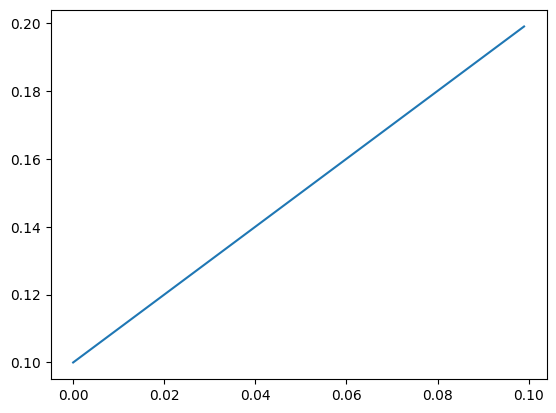

In [17]:
def integ_Euler(Vi, Vo0, Ts): 
    Vo = np.zeros(Vi.shape)
    Vo[0]=Vo0
    for i in range(1, len(Vo)):
        Vo[i]= Vo[i-1]+Vi[i]*Ts


    # Backward Euler (right Riemann): 
    # Vo[i] = Vo[i-1] + Ts * Vi[i]
    # Forward Euler (left Riemann): 
    # Vo[i] = Vo[i-1] + Ts * Vi[i-1]

    return Vo
 
Vi = np.zeros(100)+1 # step 
time = np.arange(0,Ts*len(Vi), Ts)
Ts= 1e-3
Vo0= 0.1
Vo= integ_Euler(Vi, Vo0, Ts)
plt.plot(time, Vo)

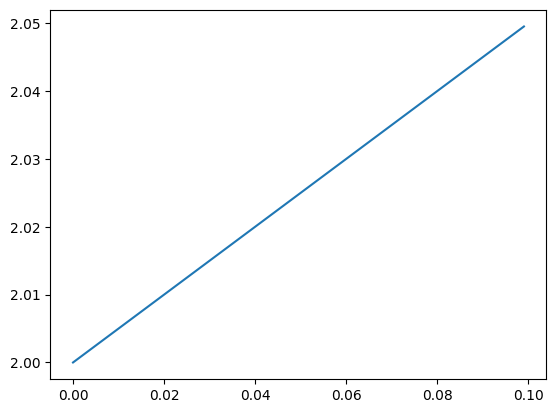

In [18]:
Vi = np.zeros(100)+1 # step 
time = np.arange(0,Ts*len(Vi), Ts)
Ts= 1e-3
Vo0= 0
def PI_controler (Vi,Vo0, Ts, Kp , Ki): 
    return Ki*integ_Euler(Vi, Vo0, Ts)+Kp*Vi
Vo= PI_controler(Vi,Vo0, Ts, Kp=2 , Ki=5e-1)
plt.plot(time, Vo)

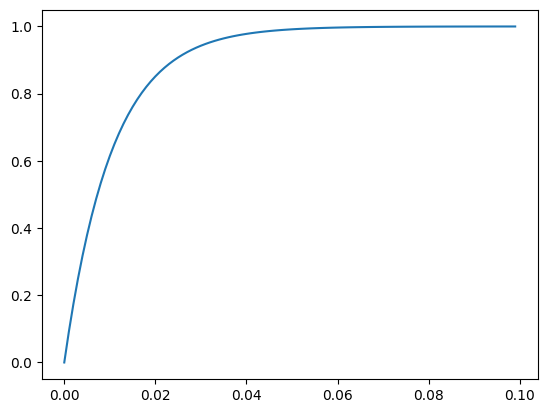

In [19]:
def first_order_backward_euler(Vi, Vo0, Ts, To):
    a = Ts / To
    Vo = np.empty_like(Vi, dtype=float)
    Vo[0] = Vo0
    for i in range(1, len(Vi)):
        Vo[i] = (Vo[i-1] + a*Vi[i]) / (1 + a)
    return Vo



Vi = np.zeros(100)+1 # step 
time = np.arange(0,Ts*len(Vi), Ts)
Ts= 1e-3
Vo0= 0
To = 1e-2

Vo = first_order_backward_euler(Vi, Vo0, Ts, To)
plt.plot(time , Vo)

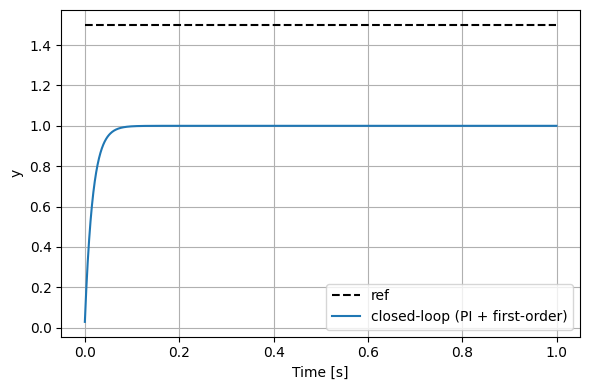

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Parameters
Ts = 1e-3
To = 1e-2
Kp = 0.6
Ti = To

# Plant G(s) = 1 / (To s + 1)
numG = np.array([1.0])
denG = np.array([To, 1.0])

# PI C(s) = Kp (Ti s + 1) / (Ti s)
numC = np.array([Kp*Ti, Kp])
denC = np.array([Ti, 0.0])

# Open-loop L(s) = C(s) G(s)
numL = np.polymul(numC, numG)
denL = np.polymul(denC, denG)

# Closed-loop T(s) = L / (1 + L) = numL / (denL + numL)
numT = numL
denT = np.polyadd(denL, numL)

# Discretize closed-loop (choose 'bilinear' (Tustin) or 'zoh')
numd, dend, _ = signal.cont2discrete((numT, denT), Ts, method='bilinear')[:3]

# Step response of the discrete closed-loop
sysd = signal.dlti(numd.squeeze(), dend.squeeze(), dt=Ts)
t, y = signal.dstep(sysd, n=1000)
t = t.squeeze()
y = y[0].squeeze()

plt.figure(figsize=(6,4))
plt.plot(t, np.ones_like(t)+0.5, 'k--', label='ref')
plt.plot(t, y, label='closed-loop (PI + first-order)')
plt.xlabel('Time [s]')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


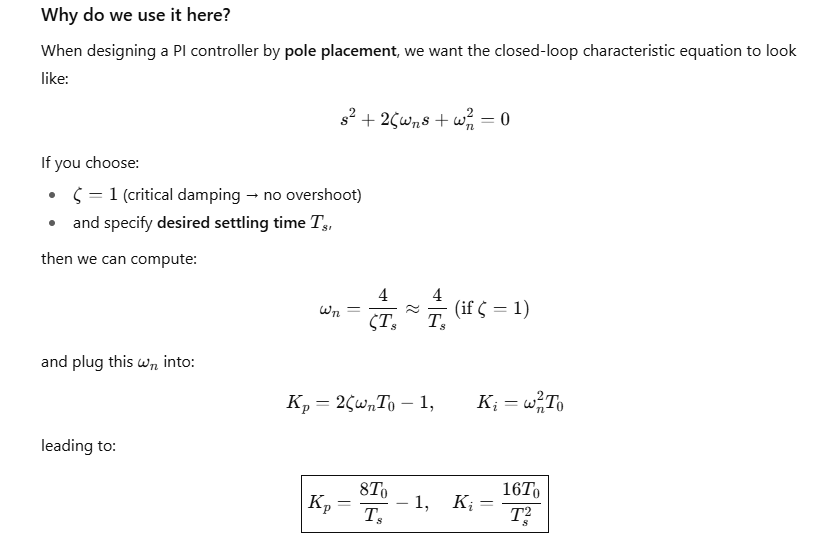

In [21]:
# First order sys: G(s) = 1/(1+To*s)

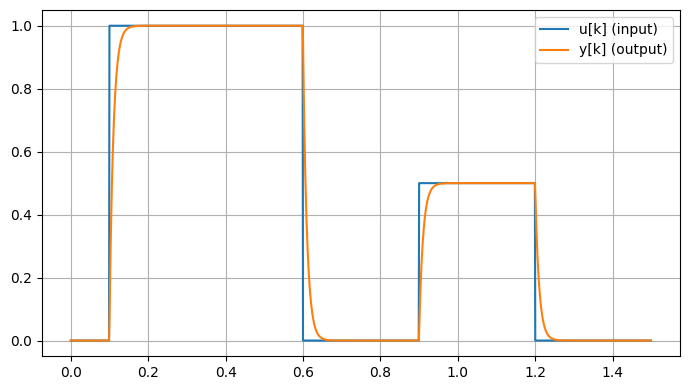

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

Ts = 1e-3
To = 1e-2

# Discretize plant G(s) = 1/(To s + 1)
numG = np.array([1.0])
denG = np.array([To, 1.0])
numd, dend, _ = signal.cont2discrete((numG, denG), Ts, method='bilinear')[:3]
numd = numd.ravel(); dend = dend.ravel()

# Your actuator input array (arbitrary)
N = 1500
u = np.zeros(N)
u[100:600] = 1.0
u[900:1200] = 0.5

# Output by filtering
y = signal.lfilter(numd, dend, u)

# Or with dlsim
sysd = signal.dlti(numd, dend, dt=Ts)
t, y2 = signal.dlsim(sysd, u)
t = t.squeeze(); y2 = y2.squeeze()

plt.figure(figsize=(7,4))
plt.plot(t, u, label='u[k] (input)')
plt.plot(t, y, label='y[k] (output)')
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


In [62]:
import numpy as np
from scipy.signal import cont2discrete

def simulate_pi_first_order(
    r, Ts, To, Kp, Ti, y0=0.0,
    umin=None, umax=None,
    method='backward_diff'  # or 'bilinear'
):
    r = np.asarray(r, dtype=float)
    N = len(r)
    
    # Continuous plant in SS form
    Ac = np.array([[-1.0/To]])
    Bc = np.array([[1.0/To]])
    Cc = np.array([[1.0]])
    Dc = np.array([[0.0]])
    
    # Discretize
    Ad, Bd, Cd, Dd, _ = cont2discrete((Ac, Bc, Cc, Dc), Ts, method=method)

    y = np.zeros(N)
    u = np.zeros(N)
    e = np.zeros(N)
    x = np.array([[y0]])  # plant state
    I = 0.0  # integrator term

    def sat(v):
        if umin is not None: v = max(umin, v)
        if umax is not None: v = min(umax, v)
        return v

    # Initial step
    y[0] = (Cc @ x + Dd * 0.0).item()
    e[0] = r[0] - y[0]
    I += (Ts/Ti) * e[0]          # backward Euler for integrator
    u[0] = sat(Kp * (e[0] + I))

    # Simulation loop
    for k in range(1, N):
        # Plant update
        x = Ad @ x + Bd * u[k-1]
        y[k] = (Cc @ x + Dd * u[k-1]).item()

        # PI control
        e[k] = r[k] - y[k]
        I += (Ts/Ti) * e[k]
        u[k] = sat(Kp * (e[k] + I))

    t = np.arange(N) * Ts
    return t, y, u, e


In [64]:
def sys_first_order(
    r, Ts, To , y0=0.0,
    umin=None, umax=None,
    method='backward_diff'  # 'bilinear' also OK
):
    r = np.asarray(r, dtype=float)
    N = len(r)
    # Continuous plant in SS form
    Ac = np.array([[-1.0/To]]); Bc = np.array([[1.0/To]])
    Cc = np.array([[1.0]]);     Dc = np.array([[0.0]])
    Ad, Bd, Cd, Dd, _ = cont2discrete((Ac, Bc, Cc, Dc), Ts, method=method)

    y = np.empty(N); u = np.empty(N); e = np.empty(N)
    x = np.array([[y0]])  # plant state
    I = 0.0

    def sat(v):
        if umin is not None: v = max(umin, v)
        if umax is not None: v = min(umax, v)
        return v

    # k=0
    y[0] = (Cc @ x + Dd * 0.0).item()
    e[0] = r[0] - y[0]
    I += (Ts/Ti) * e[0]          # backward Euler for integrator
    u_star = Kp * (e[0] + I)
    u[0] = sat(u_star)

    for k in range(1, N):
        # plant step with previous control
        x = Ad @ x + Bd * u[k-1]
        y[k] = (Cc @ x + Dd * u[k-1]).item()

        e[k] = r[k] - y[k]
        I += (Ts/Ti) * e[k]      # PI integrator
        u_star = Kp * (e[k] + I)
        u[k] = sat(u_star)

    t = np.arange(N) * Ts
    return t, y, u, e


In [65]:
import numpy as np

def sys_first_order(r, Ts, To, y0=0.0, method='backward_diff'):
    """
    Simulate first-order system: G(s) = 1 / (1 + To*s)
    
    r : array-like, input signal
    Ts: sampling time
    To: time constant
    y0: initial output
    method: 'backward_diff' or 'bilinear'
    """
    r = np.asarray(r, dtype=float)
    N = len(r)
    y = np.zeros(N)
    y[0] = y0

    if method == 'backward_diff':  # Backward Euler
        a = Ts / (To + Ts)
    elif method == 'bilinear':    # Tustin
        a = Ts / (2*To + Ts)
    else:
        raise ValueError("method must be 'backward_diff' or 'bilinear'")
    
    for k in range(1, N):
        if method == 'backward_diff':
            y[k] = y[k-1] + a * (r[k] - y[k-1])
        else:  # bilinear
            y[k] = ((1 - (Ts/(2*To))) * y[k-1] + a * (r[k] + r[k-1])) / (1 + Ts/(2*To))

    t = np.arange(N) * Ts
    return t, y


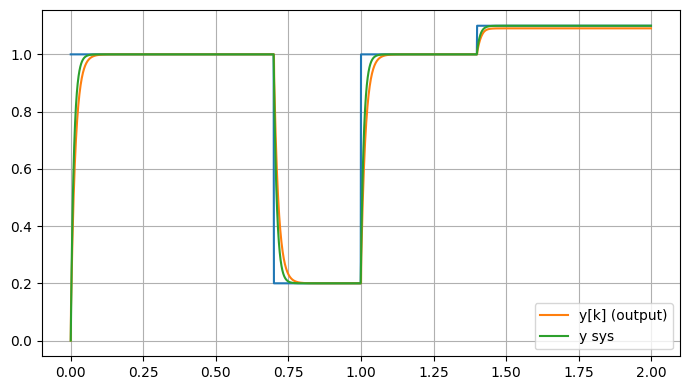

In [66]:
Ts, To, Kp, Ti = 1e-3, 1e-2, 0.6, 1e-2
r = np.ones(2000); r[700:1000] = 0.2; r[1400:] = 1.1

t, y, u, e = simulate_pi_first_order(r, Ts, To, Kp, Ti, umin=0.0, umax=1.0)
plt.figure(figsize=(7,4))
plt.plot(t, r)
#plt.plot(t, u, label='u[k] (input)')
plt.plot(t, y, label='y[k] (output)')
t, y_sys= sys_first_order(r, Ts, To, y0=0.0)
plt.plot(t, y_sys, label='y sys')

plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

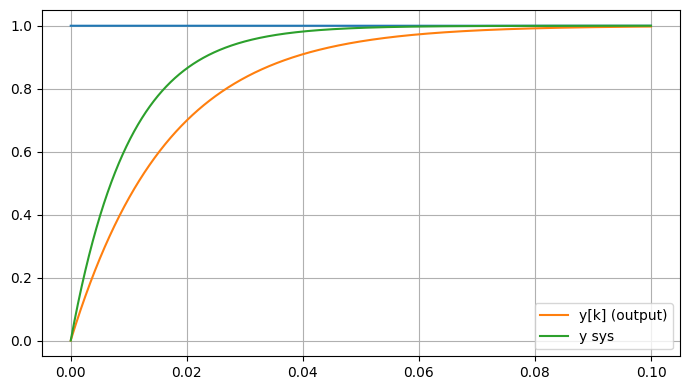

In [67]:
Ts, To, Kp, Ti = 1e-5, 1e-2, 0.6, 1e-2
Tsim = 0.1
N = int(Tsim/Ts)
r = np.ones(N)

t, y, u, e = simulate_pi_first_order(r, Ts, To, Kp, Ti, umin=0.0, umax=1.0)
plt.figure(figsize=(7,4))
plt.plot(t, r)
#plt.plot(t, u, label='u[k] (input)')
plt.plot(t, y, label='y[k] (output)')
t, y_sys= sys_first_order(r, Ts, To, y0=0.0)
plt.plot(t, y_sys, label='y sys')

plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

 The system 
 $ G(s) = \frac {1}{1+T_o . s}$ 
 <br>
 The controler 
$ PI(s) = K_p + \frac{K_i}{s} = Kp \frac {1+T_i.s}{T_i.s} $
<br> with $ T_i = \frac{K_p}{K_i}$  
Open loop <br>
$ H(s)= G(s).PI(s)= \frac {1}{1+T_o . s}  Kp \frac {1+T_i.s}{T_i.s} = \frac {Kp }{T_i.s}\frac {1+T_i.s}{1+T_o . s} : (I)$ 
 <br>
**Methode 1: Cancellation and Dominant Pole Approximation**
$T_o = T_i$
 <br>
$ H(s)= \frac {K_p}{T_i.s}$
 <br>
claused loop 
 <br>
$H_c(s)= \frac{H(s) }{ 1+H(s)}= \frac{1 }{ 1+\frac {1}{H(s)}} : (II)$ 
 <br>
$H_c(s)= \frac{1 }{ 1+\frac {T_i}{K_p}.s}= \frac{1 }{ 1+T_{oc}.s}$
 <br>
With $ T_{oc} = \frac {T_i}{K_p}$
 <br>
Example make the system n time more fast  
$ T_{oc} =\frac {T_o}{3}$
 <br>
$ Ki= \frac {n}{T_o} $
 <br>
$ T_o = T_i = \frac{K_p}{K_i}$ 
 <br>
$ K_p = T_o.K_i = n$
 <br>
**Methode 2: Dominant Pole Approximation**
 <br>
$ Hc(s) = \frac{1}{1+ \frac {T_i.s}{K_p} \frac {1+T_o . s}{1+T_i.s} }  = \frac{1+T_i.s}{1+(T_i+\frac{T_i}{K_p}).s+\frac{T_i.T_o}{K_p}.s^2}$
 <br>
$Hc(s) ≈\frac{1}{1+2\zeta\frac{s}{w_n}+\frac{s^2}{w_n^2}} $
 <br>
if $ Ti.wn <<1 $
$ w_n^2 = \frac{K_p}{T_i.T_o} $ 
 <br>
$ 2\zeta\frac{1}{w_n} = (T_i+\frac{T_i}{K_p}) $ 
 <br>
$ K_p = 2.\zeta.w_n.T_o-1$
 <br>
$ T_i= \frac{K_p}{w_n^2.T_o} $ 
<br>
$ T_i.w_n ≪ 1  \Rightarrow  T_i.w_n = \frac{K_p}{w_n.T_o}=2*\zeta -\frac{1}{w_n.T_o} ≪ 1 $
<br>
for $ \zeta=1 \Rightarrow  w_n ≪ T_o $

$ escaped brackets $

Method 1 is simple and widely used for PI tuning when the plant is well approximated by a first-order system.
Method 2 is more accurate for higher performance or when you want to control overshoot (via ζ).

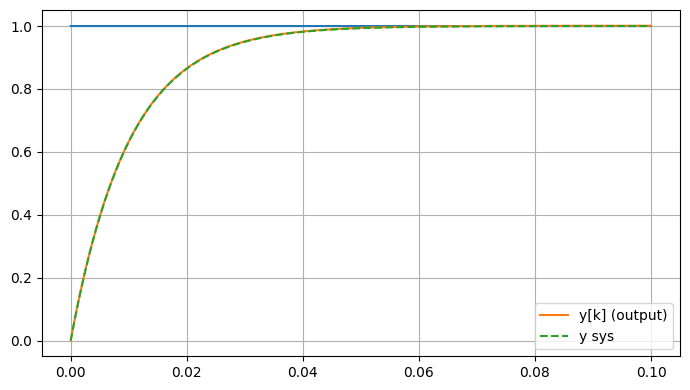

In [69]:
Ts, To = 1e-5, 1e-2
#Kp, Ti  = 0.6, 1e-2
Kp= 100
Ti   =  To/5

Tsim = 0.1
N = int(Tsim/Ts)
r = np.ones(N)

t, y, u, e = simulate_pi_first_order(r, Ts, To, Kp, Ti, umin=0.0, umax=1.0)
plt.figure(figsize=(7,4))
plt.plot(t, r)
#plt.plot(t, u, label='u[k] (input)')
plt.plot(t, y, label='y[k] (output)')
t, y_sys= sys_first_order(r, Ts, To, y0=0.0)
plt.plot(t, y_sys, label='y sys', linestyle = "--")

plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

In [12]:
import numpy as np

# --- Blocks (one-step) ---

def integ_step(x, v, Ts):
    """One-step integrator (forward Euler): x_{k+1} = x_k + Ts * v_k"""
    return x + Ts * v

def pi_step(e, I, Kp, Ti, Ts):
    """PI controller one step using the integrator block."""
    I = integ_step(I, e / Ti, Ts)   # integrate error/Ti
    u = Kp * (e + I)                # PI = Kp*e + Kp*∫(e/Ti)dt
    return u, I

def first_order_step(u, y, Ts, To):
    """First-order plant y' = (u - y)/To, one step using the integrator block."""
    dy = (u - y) / To
    y  = integ_step(y, dy, Ts)
    return y

# --- Simulation loop ---

def simulate_pi_first_order(r, Ts, To, Kp, Ti, y0=0.0):
    """
    r: 1D input (reference), length N
    returns: y (same length), u
    """
    r = np.asarray(r, dtype=float)
    N = len(r)
    y = np.empty(N); u = np.empty(N)

    yk = y0     # plant state/output
    I  = 0.0    # PI integrator state

    for k in range(N):
        e  = r[k] - yk           # error
        uk, I = pi_step(e, I, Kp, Ti, Ts)
        yk = first_order_step(uk, yk, Ts, To)
        u[k] = uk
        y[k] = yk

    return y, u

# --- Example ---
if __name__ == "__main__":
    
    r = np.ones(1000)            # 1D input array
    y, u = simulate_pi_first_order(r, Ts, To, Kp, Ti)  # y has same length as r


In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
Ts, To, Kp, Ti = 1e-3, 1e-2, 0.6, 1e-2

y, u = simulate_pi_first_order(r, Ts, To, Kp, Ti)  # y has same length as r

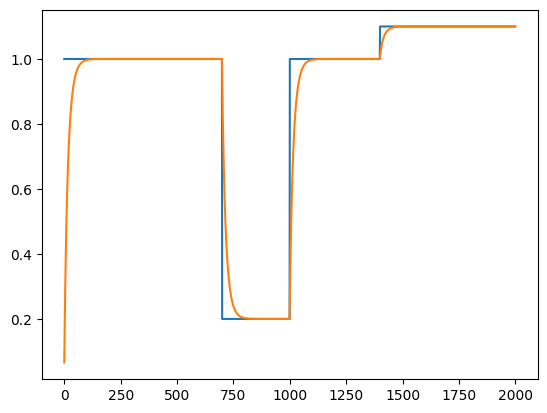

In [11]:
plt.plot(r)
plt.plot(y)
#plt.plot(u)

In [72]:
import matplotlib.pyplot as plt 
import numpy as np

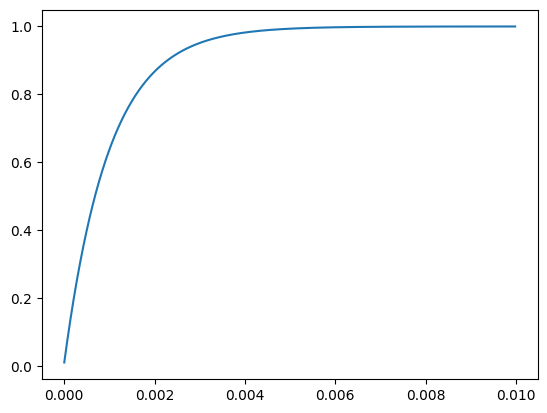

In [89]:
class FirstOrder:
    def __init__(self, To, Ts, y0=0.0):
        self.a = Ts / To
        self.y = y0
    def step(self, u):
        self.y += self.a * (u - self.y)
        return self.y
To = 1e-3
Ts = 1e-5
Tsim = 1e-2
N = int(Tsim/Ts)
time = np.arange(0,Ts*N, Ts)
u = np.ones(N)
G = FirstOrder(To, Ts)
y = []
for i in range (N): 
    y_val = G.step(u[i])
    y.append(y_val)
plt.plot(time, y)

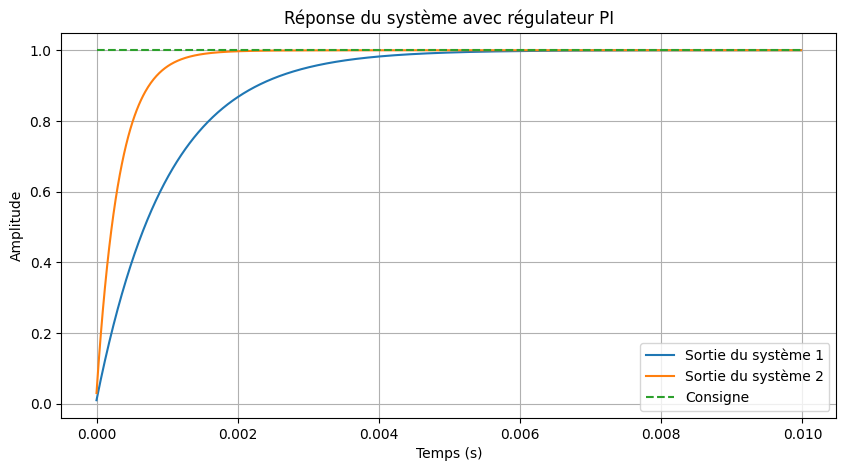

In [10]:
import numpy as np
import matplotlib.pyplot as plt

class FirstOrder:
    def __init__(self, To, Ts, y0=0.0):
        self.a = Ts / To
        self.y = y0

    def step(self, u):
        self.y += self.a * (u - self.y)
        return self.y

class PI_cont:
    def __init__(self, Kp, Ki, Ts, y0=0.0):
        # Ti = Kp/Ki
        self.Kp = Kp
        self.Ki = Ki
        self.Ts = Ts
        self.integral = 0.0
        self.y = y0

    def step(self, error):
        self.integral += error * self.Ts
        self.y = self.Kp * error + self.Ki * self.integral
        return self.y

# Paramètres
To = 1e-3
Ts = 1e-5
Tsim = 1e-2
N = int(Tsim / Ts)
time = np.arange(0, Ts * N, Ts)

# Entrée de consigne
u = np.ones(N)

# Système et régulateur
Kp = 3 # 3 time more fast 
Ti = To 
Ki = Kp/Ti 
G1 = FirstOrder(To, Ts)
G2 = FirstOrder(To, Ts)
C = PI_cont(Kp=Kp, Ki=Ki, Ts=Ts)

y1 = []
y2 = []


for i in range(N):
    # without controler
    y_val = G1.step(u[i])
    y1.append(y_val)

    # claused loop 
    error = u[i] - G2.y
    control = C.step(error)
    y_val = G2.step(control)
    y2.append(y_val)


# Affichage
plt.figure(figsize=(10, 5))
plt.plot(time, y1, label='Sortie du système 1')
plt.plot(time, y2, label='Sortie du système 2')
plt.plot(time, u, '--', label='Consigne')
plt.xlabel('Temps (s)')
plt.ylabel('Amplitude')
plt.title('Réponse du système avec régulateur PI')
plt.legend()
plt.grid(True)


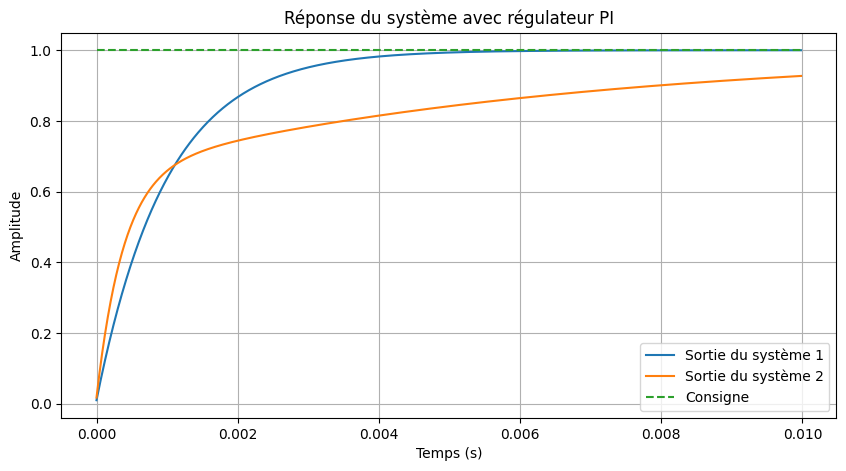

In [32]:
import numpy as np
import matplotlib.pyplot as plt

class FirstOrder:
    def __init__(self, To, Ts, y0=0.0):
        self.a = Ts / To
        self.y = y0

    def step(self, u):
        self.y += self.a * (u - self.y)
        return self.y

class PI_cont:
    def __init__(self, Kp, Ki, Ts, y0=0.0):
        # Ti = Kp/Ki
        self.Kp = Kp
        self.Ki = Ki
        self.Ts = Ts
        self.integral = 0.0
        self.y = y0

    def step(self, error):
        self.integral += error * self.Ts
        self.y = self.Kp * error + self.Ki * self.integral
        return self.y

# Paramètres

Ts = 1e-5
Tsim = 1e-2
N = int(Tsim / Ts)
time = np.arange(0, Ts * N, Ts)

# Entrée de consigne
u = np.ones(N)

# Système et régulateur
#Kp = 3 # 3 time more fast 
#Ti = To 
#Ki = Kp/Ti 

# 20% OVERSHOT 
Kp = 1.75;
Ki = 405; 

G1 = FirstOrder(To, Ts)
G2 = FirstOrder(To, Ts)
C = PI_cont(Kp=Kp, Ki=Ki, Ts=Ts)

y1 = []
y2 = []


for i in range(N):
    # without controler
    y_val = G1.step(u[i])
    y1.append(y_val)

    # claused loop 
    error = u[i] - G2.y
    control = C.step(error)
    y_val = G2.step(control)
    y2.append(y_val)


# Affichage
plt.figure(figsize=(10, 5))
plt.plot(time, y1, label='Sortie du système 1')
plt.plot(time, y2, label='Sortie du système 2')
plt.plot(time, u, '--', label='Consigne')
plt.xlabel('Temps (s)')
plt.ylabel('Amplitude')
plt.title('Réponse du système avec régulateur PI')
plt.legend()
plt.grid(True)


#### RC SIM 

0.02223752

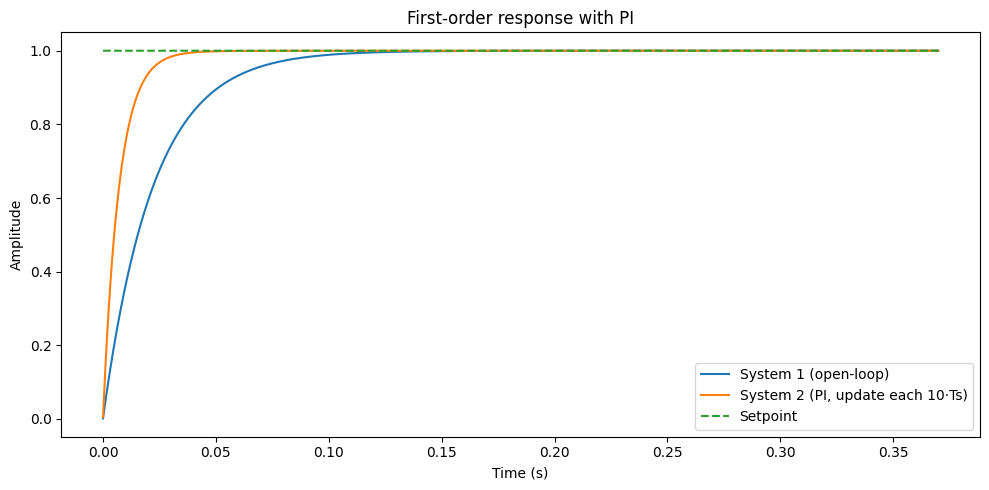

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Params
Ts = 37e-6          # plant step
Ts_ctrl = 10*Ts     # controller update every 10*Ts

N = 10000
time = np.arange(0, Ts * N, Ts)

# Input
u = np.ones(N)

# System & controller
Kp = 3
Ti = To
Ki = Kp/Ti          # or Ki = Kp*Ts_ctrl/Ti if PI_cont expects discrete gain
G1 = FirstOrder(To, Ts)
G2 = FirstOrder(To, Ts)
C  = PI_cont(Kp=Kp, Ki=Ki, Ts=Ts_ctrl)

y1, y2 = [], []
control2 = 0.0

for i in range(N):
    # open-loop
    y1.append(G1.step(u[i]))

    # closed-loop with controller update every 10 steps (ZOH in between)
    e = u[i] - G2.y
    if i % 10 == 0:
        control2 = C.step(e)
    y2.append(G2.step(control2))

# Plot
plt.figure(figsize=(10,5))
plt.plot(time, y1, label='System 1 (open-loop)')
plt.plot(time, y2, label='System 2 (PI, update each 10·Ts)')
plt.plot(time, u, '--', label='Setpoint')
plt.xlabel('Time (s)'); plt.ylabel('Amplitude')
plt.title('First-order response with PI')
plt.legend(); plt.tight_layout()
plt.show()


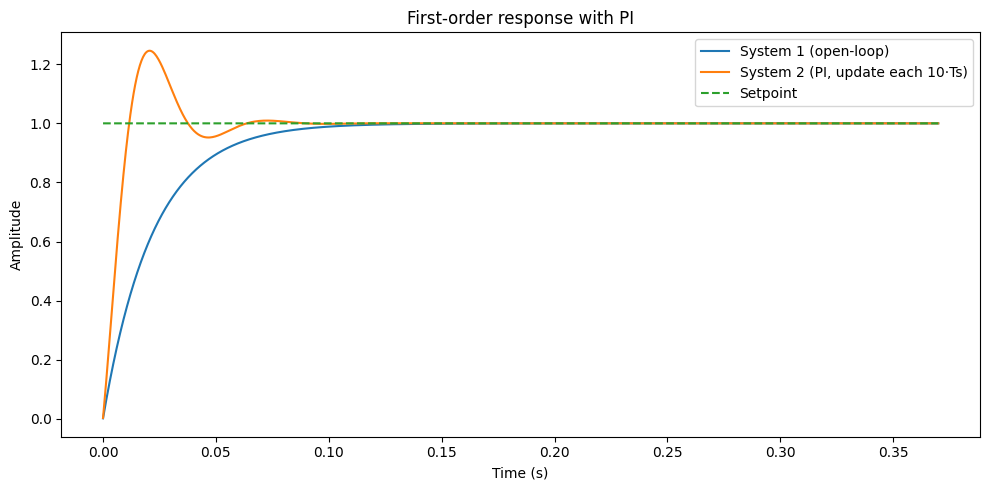

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# RC sys
R=4660#meas
C=4.772e-6# nom 4.7uF
To=R*C


# Params
Ts = 37e-6          # plant step
Ts_ctrl = 10*Ts     # controller update every 10*Ts

N = 10000
time = np.arange(0, Ts * N, Ts)

# Input
u = np.ones(N)

# System & controller
Kp = 3
Ti = To
Ki = Kp/Ti          # or Ki = Kp*Ts_ctrl/Ti if PI_cont expects discrete gain

# 20% overshot 
Kp = 1.75;
Ki = 405;  


G1 = FirstOrder(To, Ts)
G2 = FirstOrder(To, Ts)
C  = PI_cont(Kp=Kp, Ki=Ki, Ts=Ts_ctrl)

y1, y2 = [], []
control2 = 0.0

for i in range(N):
    # open-loop
    y1.append(G1.step(u[i]))

    # closed-loop with controller update every 10 steps (ZOH in between)
    e = u[i] - G2.y
    if i % 10 == 0:
        control2 = C.step(e)
    y2.append(G2.step(control2))

# Plot
plt.figure(figsize=(10,5))
plt.plot(time, y1, label='System 1 (open-loop)')
plt.plot(time, y2, label='System 2 (PI, update each 10·Ts)')
plt.plot(time, u, '--', label='Setpoint')
plt.xlabel('Time (s)'); plt.ylabel('Amplitude')
plt.title('First-order response with PI')
plt.legend(); plt.tight_layout()
plt.show()


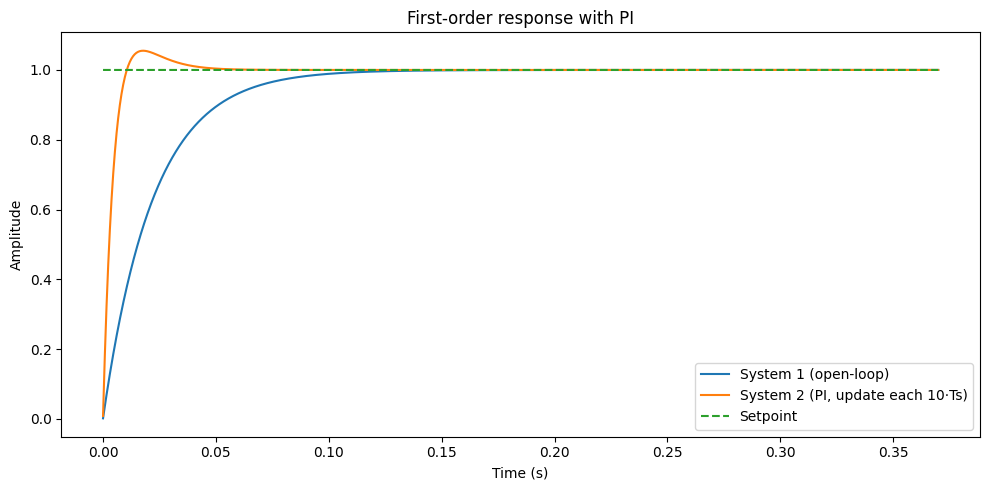

In [52]:
import numpy as np
import matplotlib.pyplot as plt


# RC sys
R=4660#meas
C=4.772e-6# nom 4.7uF
To=R*C

# Params
Ts = 37e-6          # plant step
Ts_ctrl = 10*Ts     # controller update every 10*Ts

N = 10000
time = np.arange(0, Ts * N, Ts)

# Input
u = np.ones(N)

# System & controller
# methode 2
zeta = 1
wn = 3/To
Kp = 2*zeta*wn*To-1
Ti=Kp/(To*wn**2)



G1 = FirstOrder(To, Ts)
G2 = FirstOrder(To, Ts)
C  = PI_cont(Kp=Kp, Ki=Ki, Ts=Ts_ctrl)

y1, y2 = [], []
control2 = 0.0

for i in range(N):
    # open-loop
    y1.append(G1.step(u[i]))

    # closed-loop with controller update every 10 steps (ZOH in between)
    e = u[i] - G2.y
    if i % 10 == 0:
        control2 = C.step(e)
    y2.append(G2.step(control2))

# Plot
plt.figure(figsize=(10,5))
plt.plot(time, y1, label='System 1 (open-loop)')
plt.plot(time, y2, label='System 2 (PI, update each 10·Ts)')
plt.plot(time, u, '--', label='Setpoint')
plt.xlabel('Time (s)'); plt.ylabel('Amplitude')
plt.title('First-order response with PI')
plt.legend(); plt.tight_layout()
plt.show()


In [47]:
np.array(y2).max()

np.float64(1.0551464971272853)

In [55]:
# Ti*wn << 1
Ti*wn 

1.6666666666666665

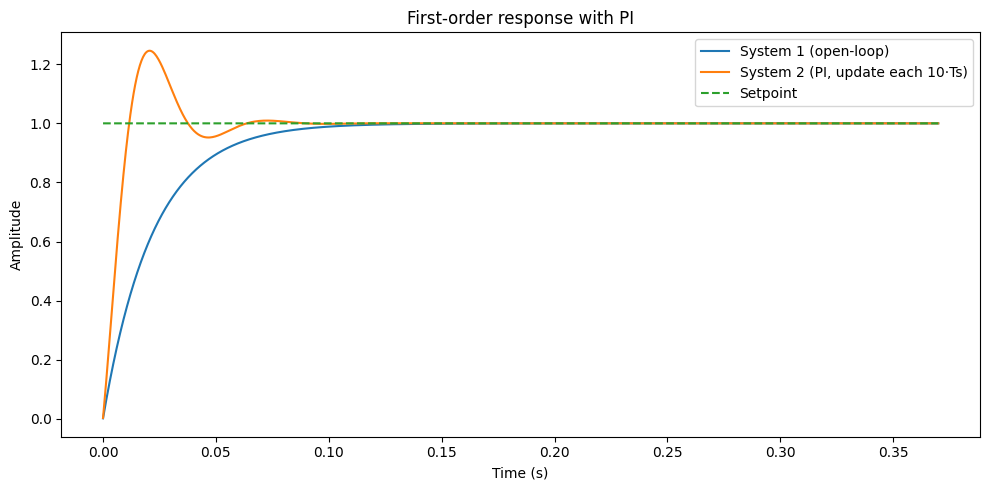

In [58]:
import numpy as np
import matplotlib.pyplot as plt

class FirstOrder:
    def __init__(self, To, Ts, y0=0.0):
        self.a = Ts / To
        self.y = y0

    def step(self, u):
        self.y += self.a * (u - self.y)
        return self.y

class PI_cont:
    def __init__(self, Kp, Ki, Ts, y0=0.0):
        # Ti = Kp/Ki
        self.Kp = Kp
        self.Ki = Ki
        self.Ts = Ts
        self.integral = 0.0
        self.y = y0

    def step(self, error):
        self.integral += error * self.Ts
        self.y = self.Kp * error + self.Ki * self.integral
        return self.y




import numpy as np
import matplotlib.pyplot as plt

# RC sys
R=4660#meas
C=4.772e-6# nom 4.7uF
To=R*C


# Params
Ts = 37e-6          # plant step
Ts_ctrl = 10*Ts     # controller update every 10*Ts

N = 10000
time = np.arange(0, Ts * N, Ts)

# Input
u = np.ones(N)

# System & controller
Kp = 3
Ti = To
Ki = Kp/Ti          # or Ki = Kp*Ts_ctrl/Ti if PI_cont expects discrete gain

# 20% overshot 
Kp = 1.75;
Ki = 405;  


G1 = FirstOrder(To, Ts)
G2 = FirstOrder(To, Ts)
C  = PI_cont(Kp=Kp, Ki=Ki, Ts=Ts_ctrl)

y1, y2 = [], []
control2 = 0.0

for i in range(N):
    # open-loop
    y1.append(G1.step(u[i]))

    # closed-loop with controller update every 10 steps (ZOH in between)
    e = u[i] - G2.y
    if i % 10 == 0:
        control2 = C.step(e)
    y2.append(G2.step(control2))

# Plot
plt.figure(figsize=(10,5))
plt.plot(time, y1, label='System 1 (open-loop)')
plt.plot(time, y2, label='System 2 (PI, update each 10·Ts)')
plt.plot(time, u, '--', label='Setpoint')
plt.xlabel('Time (s)'); plt.ylabel('Amplitude')
plt.title('First-order response with PI')
plt.legend(); plt.tight_layout()
plt.show()


In [ ]:
# Params
Ts = 37e-6          # plant step
Ts_ctrl = 10*Ts     # controller update every 10*Ts

In [ ]:
N = 10000
time = np.arange(0, Ts * N, Ts)

# Input
u = np.ones(N)

### ONE CLASS

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class FirstOrder:
    def __init__(self, To, Ts, y0=0.0):
        self.a = Ts / To
        self.y = y0

    def step(self, u):
        self.y += self.a * (u - self.y)
        return self.y

class PI_cont:
    def __init__(self, Kp, Ki, Ts, y0=0.0):
        # Ti = Kp/Ki
        self.Kp = Kp
        self.Ki = Ki
        self.Ts = Ts
        self.integral = 0.0
        self.y = y0

    def step(self, error):
        self.integral += error * self.Ts
        self.y = self.Kp * error + self.Ki * self.integral
        return self.y
        
class sim_first_1_controller_PI: 
    def __init__(self, Ts_sim, Ts_ctrl, Kp, Ki):
        self.Ts_sim = Ts_sim
        self.Ts_ctrl = Ts_ctrl
        self.Kp = Kp 
        self.Ki = Ki
    def sim(self, u):
        N = len(u)
        Ts = self.Ts_sim
        Ts_ctrl = self.Ts_ctrl
        Ts_n = int(Ts_ctrl/Ts)


        G1 = FirstOrder(To, Ts)
        G2 = FirstOrder(To, Ts)
        C  = PI_cont(Kp=Kp, Ki=Ki, Ts=Ts_ctrl)
        
        y1, y2 = [], []
        control2 = 0.0
        
        for i in range(N):
            # open-loop
            y1.append(G1.step(u[i]))
        
            # closed-loop with controller update every 10 steps (ZOH in between)
            e = u[i] - G2.y
            if i % Ts_n  == 0:
                control2 = C.step(e)
            y2.append(G2.step(control2))
        return np.array(y1), np.array(y2)




In [33]:
# RC sys
R=4660#meas
C=4.772e-6# nom 4.7uF
To=R*C

# System & controller
Kp = 3
Ti = To
Ki = Kp/Ti         

 
# simulation params
Ts_sim = 1e-6
Ts_ctrl = 100*Ts_sim

Sim_Model= sim_first_1_controller_PI(Ts_sim = Ts_sim , Ts_ctrl=Ts_ctrl, Kp=Kp, Ki=Ki)

In [34]:
Tsimulation  = 0.1

In [35]:
N = int(Tsimulation/Ts_sim)
time = np.arange(0, Ts_sim  * N, Ts_sim )
u = np.ones(N)
u[0:N//10]=0
y1, y2 = Sim_Model.sim(u)

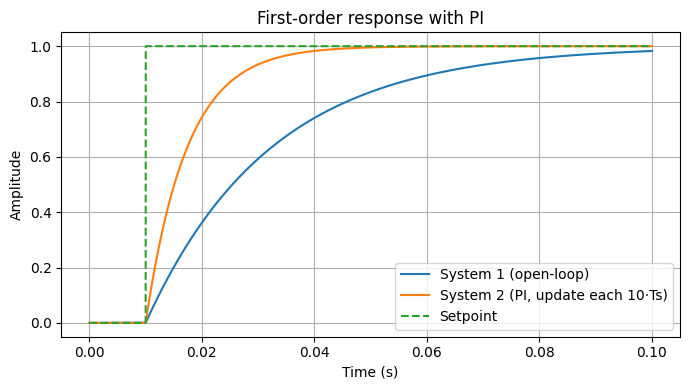

In [36]:
# Plot
plt.figure(figsize=(7,4))
plt.plot(time, y1, label='System 1 (open-loop)')
plt.plot(time, y2, label='System 2 (PI, update each 10·Ts)')
plt.plot(time, u, '--', label='Setpoint')
plt.xlabel('Time (s)'); plt.ylabel('Amplitude')
plt.title('First-order response with PI')
plt.legend(); plt.tight_layout()
plt.grid()
plt.show()



# END

In [299]:
#%pip install pyserial

In [300]:
ser.close()

In [301]:
import serial
import time

# Replace 'COM3' with your Arduino port (on Linux it may be '/dev/ttyUSB0')
ser = serial.Serial('COM5', 115200, timeout=1)  # baud rate must match Arduino
time.sleep(2)  # wait for Arduino reset
arr=[]


# Send '#' to Arduino
ser.write(b"#")  # sends the byte '#' to Arduino


try:
    while True:
        line = ser.readline().decode('utf-8').strip()  # read a line
        if line:
            #print(line)
            arr.append(line)
        if "END" in line:
            break
except KeyboardInterrupt:
    ser.close()


In [302]:
ser.close()

In [303]:
2**12

4096

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

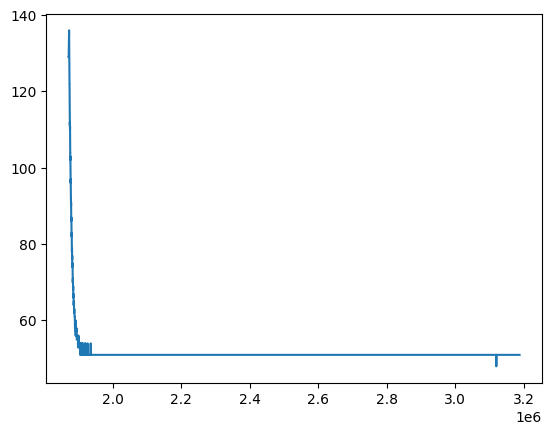

In [304]:
prin = False 
vol=[]
time=[]
for i in range(len(arr)):
    l = arr[i]
    if 'END' in l: 
        break
    if "entry" in l:
        prin=True 

    elif prin: 
        vals = arr[i].split('\t')
        time .append(float(vals[0]))
        vol .append(float(vals[1]))
plt.plot(time, vol)
plt.plot

In [305]:
import pandas as pd

In [306]:
df=pd.DataFrame({"t":time,"v":vol})
df

,t,v
0,1870676.0,129.0
1,1870810.0,129.0
2,1870942.0,130.0
3,1871074.0,131.0
4,1871206.0,132.0
...,...,...
9995,3187397.0,51.0
9996,3187528.0,51.0
9997,3187660.0,51.0
9998,3187791.0,51.0


In [307]:
100-(df.t.diff().mean()-100)

np.float64(68.26212621262127)

In [308]:
#df.to_csv("dfPI.csv")

In [313]:
df = pd.read_csv("df.csv")

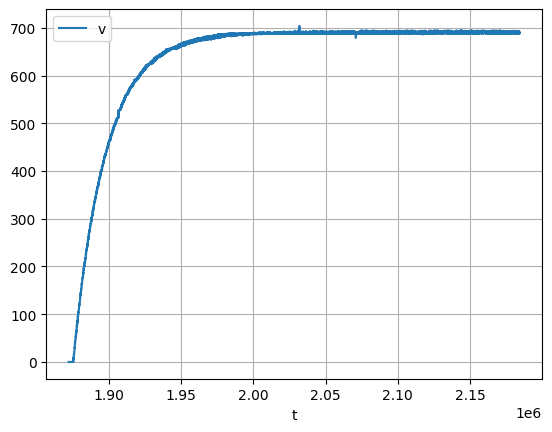

In [315]:
df.plot(x="t", y="v")
plt.grid()
#plt.ylim([None , 100])

In [316]:
df.t.diff()

0        NaN
1       32.0
2       31.0
3       31.0
4       31.0
        ... 
9995    31.0
9996    31.0
9997    31.0
9998    31.0
9999    31.0
Name: t, Length: 10000, dtype: float64

In [317]:
df.t=(df.t-df.t.iloc[0])*1e-6

(-0.01, 0.01)

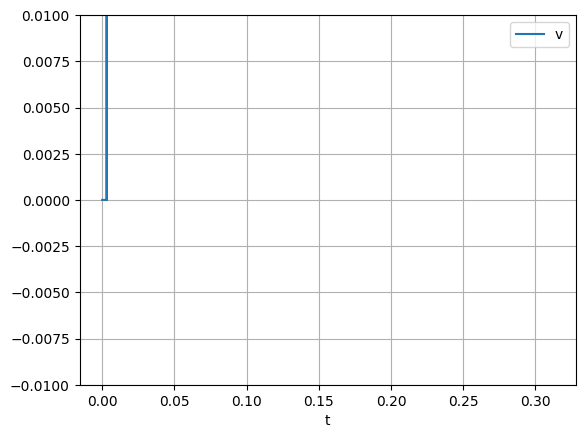

In [318]:
df.plot(x="t", y="v")
plt.grid()
lim = 0.01
plt.ylim([-lim, lim])

In [319]:
m= df.v>lim
i = int(m[m].index[0])
t0= df.loc[i, "t"]

In [320]:
n= len(df)
E0= df[(9*n)//10: n].v.mean()

In [321]:
R=4660#meas
C=4.772e-6# nom 4.7uF
To=R*C

In [322]:
vsim= 1-np.exp(-(df.t-t0)/To)
vsim*=E0
df["v2"]=vsim

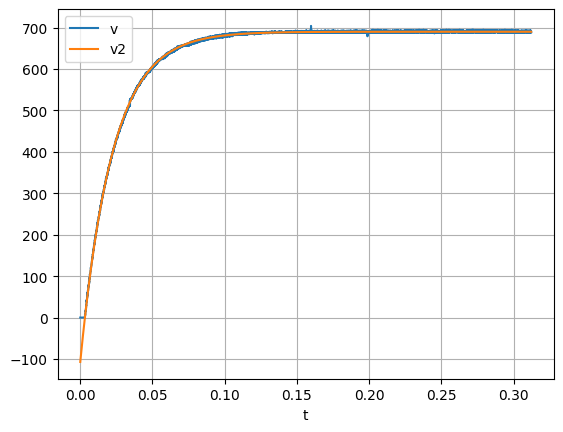

In [323]:
df.plot(x="t", y=["v", "v2"])
plt.grid()

In [ ]:
#include "driver/adc.h"
#include <Arduino.h>  // Required for ESP32 LEDC functions
#include "driver/ledc.h"

#define INP 14   // ADC2_CHANNEL_6
#define pwmPin 25
//#define PWM 25
#define PWM_GPIO 25
#include "driver/ledc.h"

#define PWM_GPIO 25


#define N 10000




// PWM configuration
const int freq = 100000;     // 100 kHz
const int ledChannel = 0;    // LEDC channel (0-15)
const int resolution = 8;    // 8-bit resolution (0-255)



int tab[N];
unsigned long ttab[N];//micros()

void setup() {
  Serial.begin(115200);
  //pinMode(PWM, OUTPUT); 
  adc2_config_channel_atten(ADC2_CHANNEL_6, ADC_ATTEN_DB_11); // GPIO14, 0-3.3V



  // Configure PWM timer: 100 kHz, 8-bit resolution
  ledc_timer_config_t t = {
    .speed_mode = LEDC_LOW_SPEED_MODE,
    .duty_resolution = LEDC_TIMER_8_BIT,
    .timer_num = LEDC_TIMER_0,
    .freq_hz = 100000,
    .clk_cfg = LEDC_AUTO_CLK
  };
  ledc_timer_config(&t);

  // Configure PWM channel
  ledc_channel_config_t c = {
    .gpio_num = PWM_GPIO,
    .speed_mode = LEDC_LOW_SPEED_MODE,
    .channel = LEDC_CHANNEL_0,
    .timer_sel = LEDC_TIMER_0,
    .duty = 0,  // 20% of 255
    .hpoint = 0
  };
  ledc_channel_config(&c);


}

void loop() {
  // wait for user to send '#'
  while (true) {
    if (Serial.available() > 0) {
      char c = Serial.read();
      if (c == '#') break; // exit loop when '#' is received
    }
  }



      ledc_set_duty(LEDC_LOW_SPEED_MODE, LEDC_CHANNEL_0, 51);
    ledc_update_duty(LEDC_LOW_SPEED_MODE, LEDC_CHANNEL_0);


  // Sampling loop
  for(int i = 0; i < N; i++){

    int val;
    adc2_get_raw(ADC2_CHANNEL_6, ADC_WIDTH_BIT_12, &val);  // ADC2 read
    tab[i] = val;
      ttab[i] = micros();  // sample index
  }
      ledc_set_duty(LEDC_LOW_SPEED_MODE, LEDC_CHANNEL_0, 0);
    ledc_update_duty(LEDC_LOW_SPEED_MODE, LEDC_CHANNEL_0);
  //digitalWrite(PWM, 0);

  // Print after sampling — safe for ADC2
  for(int i = 0; i < N; i++){
    Serial.print(ttab[i]);
    Serial.print("\t");
    Serial.println(tab[i]);
  }

  Serial.print("END");
  while(1); // stop here
}


In [ ]:
#include "driver/adc.h"
#include <Arduino.h>  // Required for ESP32 LEDC functions
#include "driver/ledc.h"

#define INP 14   // ADC2_CHANNEL_6
#define pwmPin 25
//#define PWM 25
#define PWM_GPIO 25
#include "driver/ledc.h"

#define PWM_GPIO 25


#define N 10000




// PWM configuration
const int freq = 100000;     // 100 kHz
const int ledChannel = 0;    // LEDC channel (0-15)
const int resolution = 8;    // 8-bit resolution (0-255)



int tab[N];
int ttab[N];

void setup() {
  Serial.begin(115200);
  //pinMode(PWM, OUTPUT); 
  adc2_config_channel_atten(ADC2_CHANNEL_6, ADC_ATTEN_DB_11); // GPIO14, 0-3.3V



  // Configure PWM timer: 100 kHz, 8-bit resolution
  ledc_timer_config_t t = {
    .speed_mode = LEDC_LOW_SPEED_MODE,
    .duty_resolution = LEDC_TIMER_8_BIT,
    .timer_num = LEDC_TIMER_0,
    .freq_hz = 100000,
    .clk_cfg = LEDC_AUTO_CLK
  };
  ledc_timer_config(&t);

  // Configure PWM channel
  ledc_channel_config_t c = {
    .gpio_num = PWM_GPIO,
    .speed_mode = LEDC_LOW_SPEED_MODE,
    .channel = LEDC_CHANNEL_0,
    .timer_sel = LEDC_TIMER_0,
    .duty = 0,  // 20% of 255
    .hpoint = 0
  };
  ledc_channel_config(&c);


}

void loop() {
  // wait for user to send '#'
  while (true) {
    if (Serial.available() > 0) {
      char c = Serial.read();
      if (c == '#') break; // exit loop when '#' is received
    }
  }



      ledc_set_duty(LEDC_LOW_SPEED_MODE, LEDC_CHANNEL_0, 51);
    ledc_update_duty(LEDC_LOW_SPEED_MODE, LEDC_CHANNEL_0);


  // Sampling loop
  for(int i = 0; i < N; i++){
    ttab[i] = i;  // sample index
    int val;
    adc2_get_raw(ADC2_CHANNEL_6, ADC_WIDTH_BIT_12, &val);  // ADC2 read
    tab[i] = val;
  }
      ledc_set_duty(LEDC_LOW_SPEED_MODE, LEDC_CHANNEL_0, 0);
    ledc_update_duty(LEDC_LOW_SPEED_MODE, LEDC_CHANNEL_0);
  //digitalWrite(PWM, 0);

  // Print after sampling — safe for ADC2
  for(int i = 0; i < N; i++){
    Serial.print(ttab[i]);
    Serial.print("\t");
    Serial.println(tab[i]);
  }

  Serial.print("END");
  while(1); // stop here
}


In [ ]:
#define DAC1 25       //Define Pin no 25 for DAC Output

void setup(){}

void loop() {
  dacWrite(25,125); //1.608v 3.271 not 3.3v
  dacWrite(26,200); //2.509v
/*
* here we are using 8 bit DAC so 2^8=255
* Means 0 = 0V and 255=3.3V
*/
 for (int i=0; i<255; i++){
   dacWrite(DAC1, i);          //write on DAC Pin
 }

 for (int i=255; i>=0; i--){
   dacWrite(DAC1, i);          //write on DAC Pin
 }
}

In [ ]:
#include "driver/adc.h"

#define INP 14   // ADC2_CHANNEL_6
#define PWM 25
#define N 10000

int tab[N];
int ttab[N];

void setup() {
  Serial.begin(115200);
  pinMode(PWM, OUTPUT); 
  adc2_config_channel_atten(ADC2_CHANNEL_6, ADC_ATTEN_DB_11); // GPIO14, 0-3.3V
}

void loop() {
  digitalWrite(PWM, 1);

  // Sampling loop
  for(int i = 0; i < N; i++){
    ttab[i] = i;  // sample index
    int val;
    adc2_get_raw(ADC2_CHANNEL_6, ADC_WIDTH_BIT_12, &val);  // ADC2 read
    tab[i] = val;
  }

  digitalWrite(PWM, 0);

  // Print after sampling — safe for ADC2
  for(int i = 0; i < N; i++){
    Serial.print(ttab[i]);
    Serial.print("\t");
    Serial.println(tab[i]);
  }

  while(1); // stop here
}


# PI ARDUINO 

In [68]:
R=4660#meas
C=4.772e-6# nom 4.7uF
To=R*C
To

0.02223752

In [69]:
int(255*1.1/3.3)

85

In [70]:
#%pip install pyserial

In [71]:
ser.close()

In [72]:
import serial
import time

# Replace 'COM3' with your Arduino port (on Linux it may be '/dev/ttyUSB0')
ser = serial.Serial('COM5', 115200, timeout=1)  # baud rate must match Arduino
time.sleep(2)  # wait for Arduino reset
arr=[]


# Send '#' to Arduino
ser.write(b"#")  # sends the byte '#' to Arduino


try:
    while True:
        line = ser.readline().decode('utf-8').strip()  # read a line
        if line:
            #print(line)
            arr.append(line)
        if "END" in line:
            break
except KeyboardInterrupt:
    ser.close()


In [73]:
ser.close()

In [74]:
2**12

4096

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

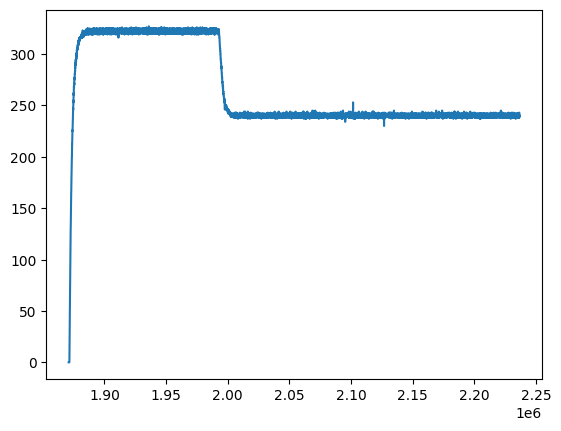

In [75]:
prin = False 
vol=[]
time=[]
for i in range(len(arr)):
    l = arr[i]
    if 'END' in l: 
        break
    if "entry" in l:
        prin=True 

    elif prin: 
        vals = arr[i].split('\t')
        time .append(float(vals[0]))
        vol .append(float(vals[1]))
plt.plot(time, vol)
plt.plot

In [76]:
import pandas as pd

In [77]:
df=pd.DataFrame({"t":time,"v":vol})
df

,t,v
0,1870930.0,0.0
1,1871038.0,0.0
2,1871075.0,0.0
3,1871111.0,0.0
4,1871151.0,0.0
...,...,...
9995,2236433.0,239.0
9996,2236470.0,240.0
9997,2236506.0,240.0
9998,2236542.0,240.0


In [78]:
100-(df.t.diff().mean()-100)

np.float64(163.43144314431441)

In [79]:
df.to_csv("dfPI.csv")

In [80]:
df = pd.read_csv("dfPI.csv")

<Axes: xlabel='t'>

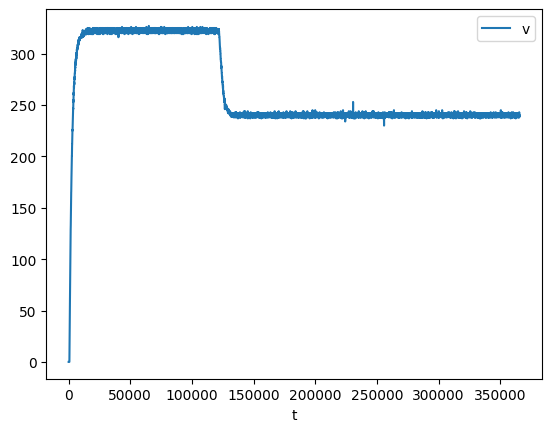

In [81]:
df.t=df.t-df.t.iloc[0]
df.plot(x='t',y='v')

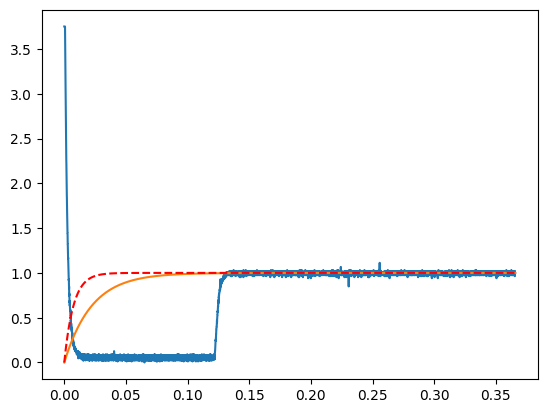

In [82]:
v= df.v.values
v= v-v.max()
v= v/v.min()
n= len(v)
E= v[(9*n)//10:].mean()
v= v/E
t = (df.t*1e-6).values

plt.plot(t, v)


v2 = (1-np.exp(-t/To))
plt.plot(t, v2)

v2 = (1-np.exp(-t*3/To))
plt.plot(t, v2,linestyle= "--", c= "r")

# PI ARDUINO pols cancel

In [422]:
R=4660#meas
C=4.772e-6# nom 4.7uF
To=R*C
To

0.02223752

In [423]:
int(255*1.1/3.3)

85

In [438]:
#%pip install pyserial

In [451]:
ser.close()

In [452]:
import serial
import time

# Replace 'COM3' with your Arduino port (on Linux it may be '/dev/ttyUSB0')
ser = serial.Serial('COM5', 115200, timeout=1)  # baud rate must match Arduino
time.sleep(2)  # wait for Arduino reset
arr=[]


# Send '#' to Arduino
ser.write(b"#")  # sends the byte '#' to Arduino


try:
    while True:
        line = ser.readline().decode('utf-8').strip()  # read a line
        if line:
            #print(line)
            arr.append(line)
        if "END" in line:
            break
except KeyboardInterrupt:
    ser.close()


In [453]:
ser.close()

In [454]:
2**12

4096

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

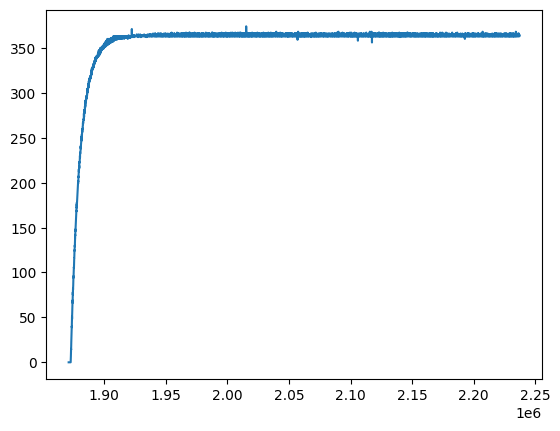

In [455]:
prin = False 
vol=[]
time=[]
for i in range(len(arr)):
    l = arr[i]
    if 'END' in l: 
        break
    if "entry" in l:
        prin=True 

    elif prin: 
        vals = arr[i].split('\t')
        time .append(float(vals[0]))
        vol .append(float(vals[1]))
plt.plot(time, vol)
plt.plot

In [456]:
import pandas as pd

In [457]:
df=pd.DataFrame({"t":time,"v":vol})
df

,t,v
0,1871144.0,0.0
1,1871252.0,0.0
2,1871290.0,0.0
3,1871326.0,0.0
4,1871363.0,0.0
...,...,...
9995,2237006.0,363.0
9996,2237044.0,363.0
9997,2237081.0,363.0
9998,2237117.0,363.0


In [458]:
100-(df.t.diff().mean()-100)

np.float64(163.3954395439544)

In [459]:
df.to_csv("dfPI2.csv")

In [460]:
df = pd.read_csv("dfPI2.csv")

<Axes: xlabel='t'>

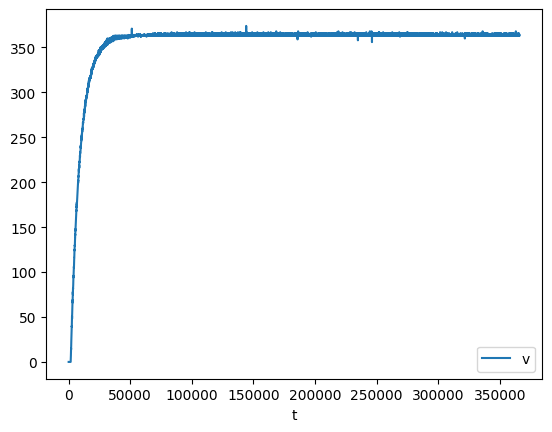

In [461]:
df.t=df.t-df.t.iloc[0]
df.plot(x='t',y='v')

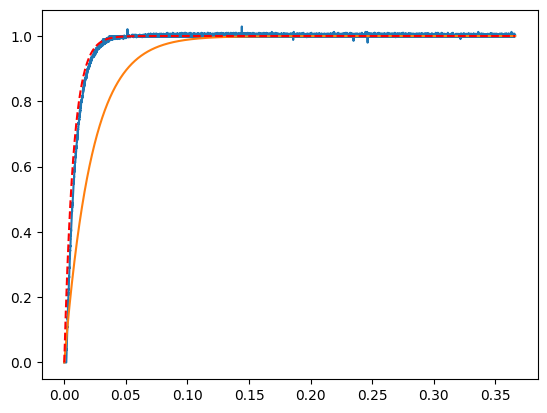

In [462]:
v= df.v.values
v= v-v.min()
v= v/v.max()
n= len(v)
E= v[(9*n)//10:].mean()
v= v/E
t = (df.t*1e-6).values

plt.plot(t, v)


v2 = (1-np.exp(-t/To))
plt.plot(t, v2)

v2 = (1-np.exp(-t*3/To))
plt.plot(t, v2,linestyle= "--", c= "r")

# PI ARDUINO 20% overshot 

In [479]:
#%pip install pyserial

In [480]:
ser.close()

In [481]:
import serial
import time

# Replace 'COM3' with your Arduino port (on Linux it may be '/dev/ttyUSB0')
ser = serial.Serial('COM5', 115200, timeout=1)  # baud rate must match Arduino
time.sleep(2)  # wait for Arduino reset
arr=[]


# Send '#' to Arduino
ser.write(b"#")  # sends the byte '#' to Arduino


try:
    while True:
        line = ser.readline().decode('utf-8').strip()  # read a line
        if line:
            #print(line)
            arr.append(line)
        if "END" in line:
            break
except KeyboardInterrupt:
    ser.close()


In [482]:
ser.close()

In [483]:
2**12

4096

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

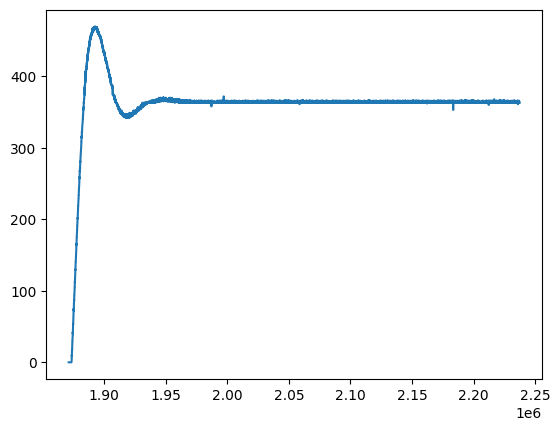

In [484]:
prin = False 
vol=[]
time=[]
for i in range(len(arr)):
    l = arr[i]
    if 'END' in l: 
        break
    if "entry" in l:
        prin=True 

    elif prin: 
        vals = arr[i].split('\t')
        time .append(float(vals[0]))
        vol .append(float(vals[1]))
plt.plot(time, vol)
plt.plot

In [488]:
import pandas as pd

In [489]:
df=pd.DataFrame({"t":time,"v":vol})
df

,t,v
0,1871334.0,0.0
1,1871438.0,0.0
2,1871476.0,0.0
3,1871512.0,0.0
4,1871549.0,0.0
...,...,...
9995,2237069.0,363.0
9996,2237105.0,363.0
9997,2237142.0,363.0
9998,2237182.0,363.0


In [490]:
100-(df.t.diff().mean()-100)

np.float64(163.40794079407942)

In [491]:
df.to_csv("dfPI3.csv")

In [492]:
df = pd.read_csv("dfPI3.csv")

<Axes: xlabel='t'>

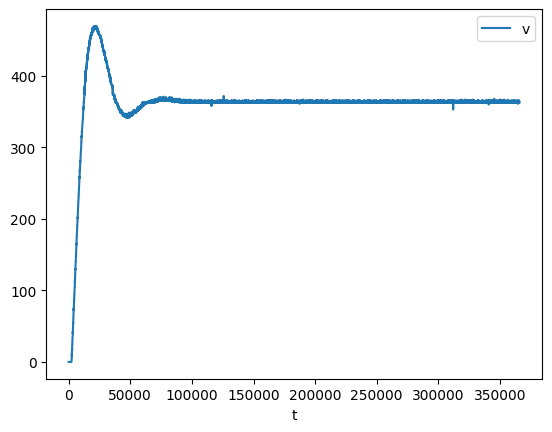

In [493]:
df.t=df.t-df.t.iloc[0]
df.plot(x='t',y='v')

In [510]:
df.t.diff()

0         NaN
1       104.0
2        38.0
3        36.0
4        37.0
        ...  
9995     36.0
9996     36.0
9997     37.0
9998     40.0
9999     36.0
Name: t, Length: 10000, dtype: float64

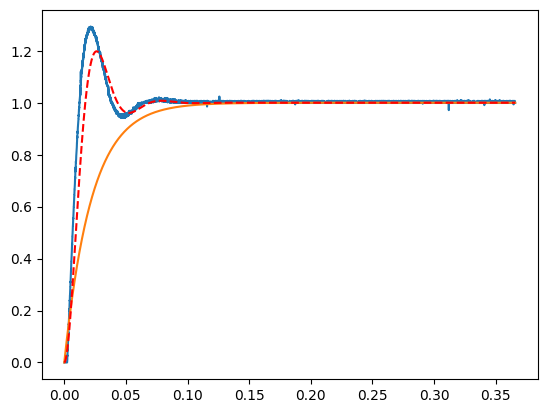

In [513]:
v= df.v.values
v= v-v.min()
v= v/v.max()
n= len(v)
E= v[(9*n)//10:].mean()
v= v/E
t = (df.t*1e-6).values

plt.plot(t, v)


v2 = (1-np.exp(-t/To))
plt.plot(t, v2)

#v2 = (1-np.exp(-t*3/To))
#plt.plot(t, v2,linestyle= "--", c= "r")








Kp = 1.75;
Ki = 405;  
wn= np.sqrt(Ki/To)
m = (1+Kp)/(2*np.sqrt(Ki*To))
wd = wn*np.sqrt(1-m**2)
#y = 1-np.exp(-m*wn*t)*np.sin(wd*t+np.arctan(np.sqrt(1-m**2)/m))/np.sqrt(1-m**2)

y = 1-np.exp(-m*wn*t)*np.sin(wd*t + np.arctan2(np.sqrt(1-m**2), m)) / np.sqrt(1 - m**2)

plt.plot(t, y,linestyle= "--", c= "r")

In [516]:
v.max(), y.max()

(np.float64(1.293607651551641), np.float64(1.19802220809595))

# PI ARDUINO CHANGE REF 

In [12]:
import matplotlib.pyplot as plt 
import numpy as np

In [13]:
R=4660#meas
C=4.772e-6# nom 4.7uF
To=R*C
To

0.02223752

In [14]:
int(255*1.1/3.3)

85

In [29]:
#%pip install pyserial

In [30]:
ser.close()

In [31]:
import serial
import time

# Replace 'COM3' with your Arduino port (on Linux it may be '/dev/ttyUSB0')
ser = serial.Serial('COM5', 115200, timeout=1)  # baud rate must match Arduino
time.sleep(2)  # wait for Arduino reset
arr=[]


# Send '#' to Arduino
ser.write(b"#")  # sends the byte '#' to Arduino


try:
    while True:
        line = ser.readline().decode('utf-8').strip()  # read a line
        if line:
            #print(line)
            arr.append(line)
        if "END" in line:
            break
except KeyboardInterrupt:
    ser.close()


In [32]:
ser.close()

In [33]:
2**12

4096

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

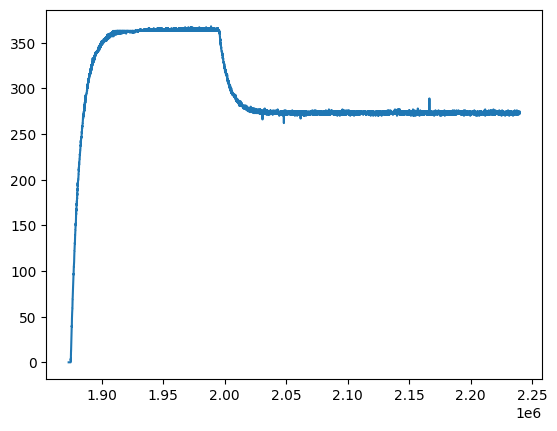

In [34]:
prin = False 
vol=[]
time=[]
for i in range(len(arr)):
    l = arr[i]
    if 'END' in l: 
        break
    if "entry" in l:
        prin=True 

    elif prin: 
        vals = arr[i].split('\t')
        time .append(float(vals[0]))
        vol .append(float(vals[1]))
plt.plot(time, vol)
plt.plot

In [35]:
import pandas as pd

In [36]:
df=pd.DataFrame({"t":time,"v":vol})
df

,t,v
0,1873272.0,0.0
1,1873374.0,0.0
2,1873411.0,0.0
3,1873448.0,0.0
4,1873484.0,0.0
...,...,...
9995,2239567.0,273.0
9996,2239603.0,272.0
9997,2239640.0,272.0
9998,2239676.0,275.0


In [37]:
100-(df.t.diff().mean()-100)

np.float64(163.35223522352234)

In [38]:
df.to_csv("dfPI4.csv")

In [39]:
df = pd.read_csv("dfPI4.csv")

<Axes: xlabel='t'>

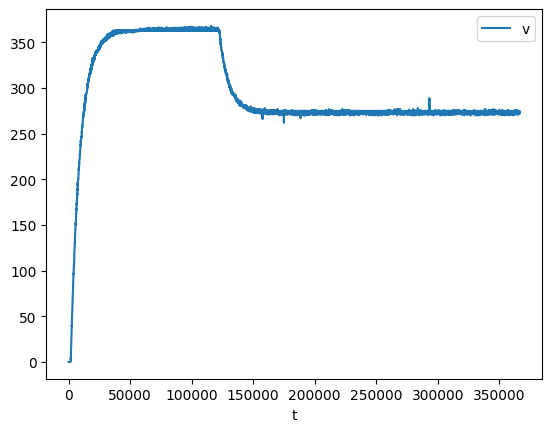

In [40]:
df.t=df.t-df.t.iloc[0]
df.plot(x='t',y='v')

# PI ARDUINO CHANGE REF 2

In [37]:
import matplotlib.pyplot as plt 
import numpy as np

In [38]:
R=4660#meas
C=4.772e-6# nom 4.7uF
To=R*C
To

0.02223752

In [39]:
int(255*1.1/3.3)

85

In [40]:
#%pip install pyserial

In [57]:
ser.close()

In [58]:
import serial
import time

# Replace 'COM3' with your Arduino port (on Linux it may be '/dev/ttyUSB0')
ser = serial.Serial('COM5', 115200, timeout=1)  # baud rate must match Arduino
time.sleep(2)  # wait for Arduino reset
arr=[]


# Send '#' to Arduino
ser.write(b"#")  # sends the byte '#' to Arduino


try:
    while True:
        line = ser.readline().decode('utf-8').strip()  # read a line
        if line:
            #print(line)
            arr.append(line)
        if "END" in line:
            break
except KeyboardInterrupt:
    ser.close()


In [59]:
ser.close()

In [60]:
2**12

4096

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

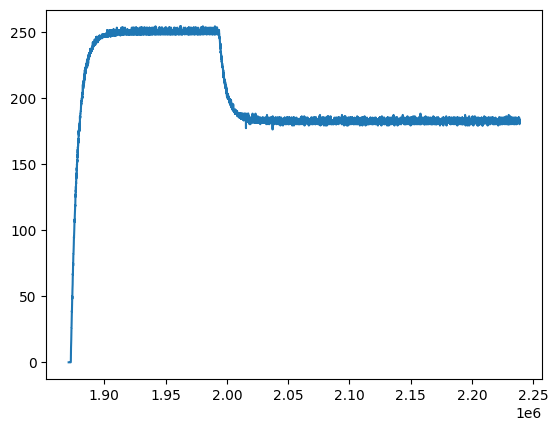

In [61]:
prin = False 
vol=[]
time=[]
for i in range(len(arr)):
    l = arr[i]
    if 'END' in l: 
        break
    if "entry" in l:
        prin=True 

    elif prin: 
        vals = arr[i].split('\t')
        time .append(float(vals[0]))
        vol .append(float(vals[1]))
plt.plot(time, vol)
plt.plot

In [62]:
import pandas as pd

In [63]:
df=pd.DataFrame({"t":time,"v":vol})
df

,t,v
0,1871030.0,0.0
1,1871137.0,0.0
2,1871178.0,0.0
3,1871214.0,0.0
4,1871250.0,0.0
...,...,...
9995,2238495.0,181.0
9996,2238532.0,181.0
9997,2238568.0,180.0
9998,2238605.0,181.0


In [64]:
100-(df.t.diff().mean()-100)

np.float64(163.23522352235224)

In [65]:
df.to_csv("dfPI5.csv")

In [66]:
df = pd.read_csv("dfPI5.csv")

<Axes: xlabel='t'>

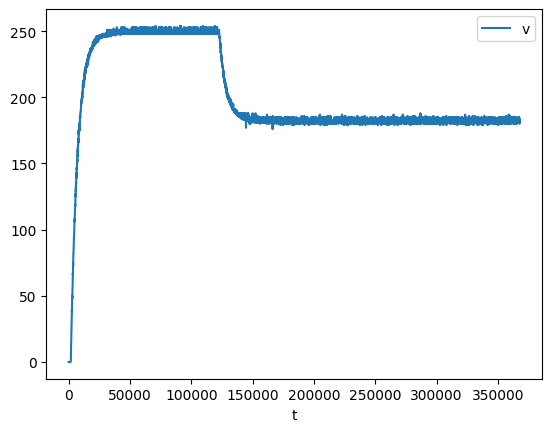

In [67]:
df.t=df.t-df.t.iloc[0]
df.plot(x='t',y='v')

# PI ARDUINO CHANGE REF 3

In [98]:
import matplotlib.pyplot as plt 
import numpy as np

In [99]:
R=4660#meas
C=4.772e-6# nom 4.7uF
To=R*C
To

0.02223752

In [100]:
int(255*1.1/3.3)

85

In [101]:
#%pip install pyserial

In [102]:
ser.close()

In [103]:
import serial
import time

# Replace 'COM3' with your Arduino port (on Linux it may be '/dev/ttyUSB0')
ser = serial.Serial('COM5', 115200, timeout=1)  # baud rate must match Arduino
time.sleep(2)  # wait for Arduino reset
arr=[]


# Send '#' to Arduino
ser.write(b"#")  # sends the byte '#' to Arduino


try:
    while True:
        line = ser.readline().decode('utf-8').strip()  # read a line
        if line:
            #print(line)
            arr.append(line)
        if "END" in line:
            break
except KeyboardInterrupt:
    ser.close()


In [104]:
ser.close()

In [105]:
2**12

4096

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

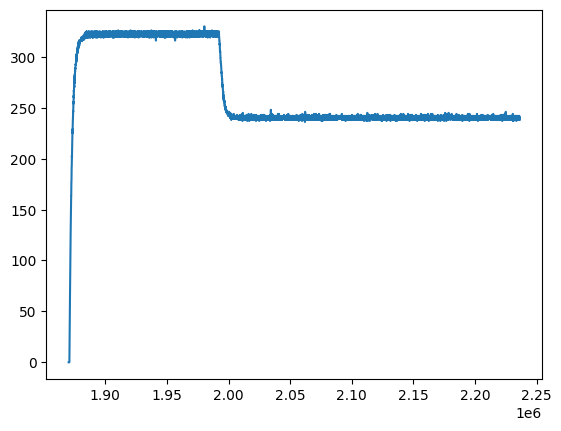

In [106]:
prin = False 
vol=[]
time=[]
for i in range(len(arr)):
    l = arr[i]
    if 'END' in l: 
        break
    if "entry" in l:
        prin=True 

    elif prin: 
        vals = arr[i].split('\t')
        time .append(float(vals[0]))
        vol .append(float(vals[1]))
plt.plot(time, vol)
plt.plot

In [107]:
import pandas as pd

In [108]:
df=pd.DataFrame({"t":time,"v":vol})
df

,t,v
0,1870291.0,0.0
1,1870398.0,0.0
2,1870434.0,0.0
3,1870471.0,0.0
4,1870507.0,0.0
...,...,...
9995,2236006.0,240.0
9996,2236045.0,239.0
9997,2236081.0,240.0
9998,2236117.0,240.0


In [109]:
100-(df.t.diff().mean()-100)

np.float64(163.4096409640964)

In [110]:
#df.to_csv("dfPI5.csv")

In [111]:
#df = pd.read_csv("dfPI5.csv")

<Axes: xlabel='t'>

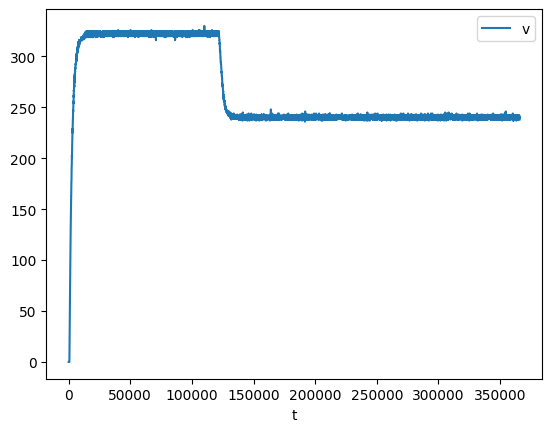

In [112]:
df.t=df.t-df.t.iloc[0]
df.plot(x='t',y='v')

# PI ARDUINO CHANGE REF 4

In [71]:
import matplotlib.pyplot as plt 
import numpy as np

In [72]:
R=4660#meas
C=4.772e-6# nom 4.7uF
To=R*C
To

0.02223752

In [73]:
int(255*1.1/3.3)

85

In [74]:
#%pip install pyserial

In [66]:
import serial
import time
import matplotlib.pyplot as plt 
import numpy as np
def Get_Data(port = 'COM5', bps= 115200):
    # Replace 'COM3' with your Arduino port (on Linux it may be '/dev/ttyUSB0')
    ser = serial.Serial(port, bps, timeout=1)  # baud rate must match Arduino
    time.sleep(2)  # wait for Arduino reset
    arr=[]
    
    
    # Send '#' to Arduino
    ser.write(b"#")  # sends the byte '#' to Arduino
    
    
    try:
        while True:
            line = ser.readline().decode('utf-8').strip()  # read a line
            if line:
                #print(line)
                arr.append(line)
            if "END" in line:
                break
    except KeyboardInterrupt:
        ser.close()
    
    
    ser.close()
    return arr 

In [67]:
import pandas as pd 
def arr_to_df(arr, cols = None):
    arr2= []
    for x in arr[::-1]: 
        if x=="END": 
            continue 
        try: 
            arr2.append(np.array(x.split('\t')).astype("int"))
        except: 
            break
    if cols is None: 
        df = pd.DataFrame(arr2)
    else : 
        df = pd.DataFrame(arr2, columns = cols)
    return df
        

<Axes: xlabel='t'>

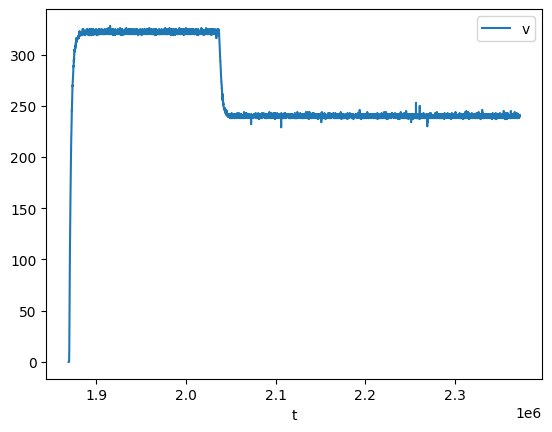

In [71]:
arr =Get_Data( 'COM5')
df = arr_to_df(arr, cols =["t", "v"])
df.plot(x="t", y="v")

In [78]:
len(df)

10000

<Axes: xlabel='t'>

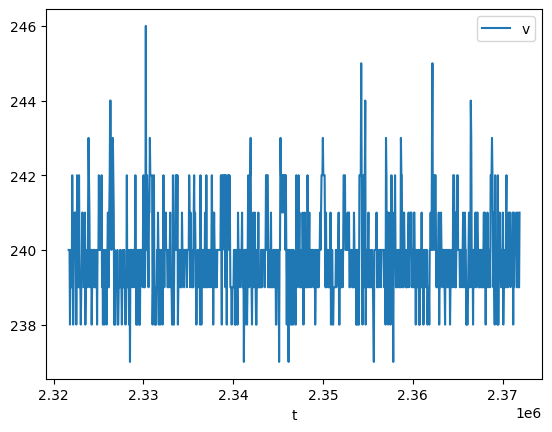

In [77]:
df.iloc[:-9*len(df)//10].plot(x="t", y="v")

In [74]:
df.t.diff()

0         NaN
1       -50.0
2       -51.0
3       -51.0
4       -50.0
        ...  
9995    -50.0
9996    -50.0
9997    -50.0
9998    -50.0
9999   -105.0
Name: t, Length: 10000, dtype: float64

In [75]:
df.head()

,t,v
0,2371879,241
1,2371829,239
2,2371778,239
3,2371727,240
4,2371677,241
